In [ ]:
!python -m spacy download es_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.9 MB 1.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import string as st
import re
from nltk.stem import SnowballStemmer
from nltk import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import spacy
import es_core_news_sm
import time
sp = es_core_news_sm.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Let's us read the input data
df = pd.read_csv('/content/drive/MyDrive/TFM/data/export_expedientes_cleaned.csv', sep=',', encoding='UTF8')
df.head()

,id_capitulo,id_concepto,id_partida_generica,descripcion,clean_text
0,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN LA COO...,servicio profesional consistente coordinación ...
1,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,servicio profesional consistente coadyuvar des...
2,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,servicio profesional consistente coadyuvar man...
3,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,servicio profesional consistente coadyuvar log...
4,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,servicio profesional consistente coadyuvar log...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617067 entries, 0 to 617066
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id_capitulo          617067 non-null  int64 
 1   id_concepto          617067 non-null  int64 
 2   id_partida_generica  617067 non-null  int64 
 3   descripcion          617067 non-null  object
 4   clean_text           617067 non-null  object
dtypes: int64(3), object(2)
memory usage: 23.5+ MB


In [ ]:
df.isnull().sum()

id_capitulo            0
id_concepto            0
id_partida_generica    0
descripcion            0
dtype: int64

In [ ]:
df = df.sample(n=50000, random_state=1)
df

,id_capitulo,id_concepto,id_partida_generica,descripcion
246729,2000,2500,2530,Infliximab SOLUCIÓN INYECTABLE El frasco ámpul...
71686,3000,3200,3250,SERVICIO DE ARRENDAMIENTO INTEGRAL DE VEHÍCULO...
26815,6000,6100,6150,Invitación E350-2018 Seguimiento y control par...
294323,3000,3500,3510,TRABAJOS DE REHABILTACIÓN Y MANTTO. EN LA ESTA...
224244,2000,2500,2530,ADQUISICION DE INSUMOS DE LISOSOMALES (IDURSUL...
...,...,...,...,...
496893,3000,3300,3390,PRESTACIÓN DE SERVICIOS PROFESIONALES DGAQ
299737,3000,3200,3270,Suscripción anual del servicio de correo elect...
73851,3000,3500,3580,CONTRATACIÓN PLURIANUAL DEL SERVICIO INTEGRAL ...
157176,3000,3100,3170,CONTRATACION DE SERVICIO DE CONDUCCION DE SEÑA...


In [ ]:
df.groupby(['id_capitulo']).count()['descripcion']

id_capitulo
2000    271604
3000    269757
5000     17605
6000     67202
Name: descripcion, dtype: int64

### TF-IDF : Term Frequency - Inverse Document Frequency
#### The term frequency is the number of times a term occurs in a document. Inverse document frequency is an inverse function of the number of documents in which a given word occurs.
#### The product of these two terms gives tf-idf weight for a word in the corpus. The higher the frequency of occurrence of a word, lower is it's weight and vice-versa. This gives more weightage to rare terms in the corpus and penalizes more commonly occuring terms.
#### Other widely used vectorizer is Count vectorizer which only considers the frequency of occurrence of a word across the corpus.


In [ ]:
# Everything looks ok. Now let's do the train-split as we did before.
X = df['clean_text'] # Text
Y = df['id_concepto'] # Labels

In [ ]:
# Para solo mantener el valor númerico sin ceros 
Y = Y.apply(lambda division: str(int(division/100.0)))

In [ ]:
# Training = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle = True, random_state=0)

In [ ]:
#La proporcion de training and testing
print(X_train.shape)
print(X_test.shape)

(493653,)
(123414,)


In [ ]:
y_train.groupby(y_train).size()

id_concepto
21     15380
22      8262
23     86881
24      7852
25     73370
26      5027
27      5795
28       473
29      9362
31      9950
32      9887
33    123053
34      4404
35     50869
36      6060
37      2477
38      2228
39      5166
51      3907
52       730
53      4276
54      1250
55       108
56      2537
57        50
58       466
59       331
61     38426
62     13930
63      1146
Name: id_concepto, dtype: int64

In [ ]:
y_test.groupby(y_test).size()

id_concepto
21     3845
22     2065
23    21720
24     1963
25    18342
26     1257
27     1449
28      118
29     2341
31     2488
32     2472
33    30763
34     1101
35    12717
36     1515
37      619
38      557
39     1292
51      977
52      183
53     1069
54      313
55       27
56      634
57       12
58      116
59       82
61     9607
62     3483
63      287
Name: id_concepto, dtype: int64

In [ ]:
# Convert lemmatized words to Tf-Idf feature vectors
tfidf = TfidfVectorizer(ngram_range=(1,3),
                        analyzer="word", 
                        tokenizer=word_tokenize, 
                        strip_accents='ascii', 
                        max_features=None, 
                        lowercase=True)
tfidf_vect = tfidf.fit(df['clean_text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [ ]:
print(len(tfidf.get_feature_names()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


2368797


In [ ]:
# Get feature names in the vector
tfidf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1',
 '1 1',
 '1 1 pre',
 '1 3',
 '1 3 cuartar',
 '1 3 quintar',
 '1 3 secundario',
 '1 abril',
 '1 abril junio',
 '1 acabar',
 '1 acabar pintura',
 '1 adquisicion',
 '1 adquisicion arrendamiento',
 '1 agostar',
 '1 agostar agostar',
 '1 anexar',
 '1 anexar modificatorio',
 '1 anticorrosivo',
 '1 anticorrosivo mano',
 '1 aplicacion',
 '1 aplicacion pintura',
 '1 aplicacion radiografiar',
 '1 apoyar',
 '1 apoyar tecnico',
 '1 asistente',
 '1 asistente direccion',
 '1 astronauta',
 '1 astronauta mexicano',
 '1 auditorio',
 '1 auditorio anual',
 '1 aula',
 '1 aula privar',
 '1 auxiliar',
 '1 auxiliar supervision',
 '1 background',
 '1 background blocker',
 '1 barrio',
 '1 barrio ejido',
 '1 bimestre',
 '1 bimestre ejercicio',
 '1 blocar',
 '1 blocar ademas',
 '1 blocar ciclar',
 '1 blocar ciencia',
 '1 blocar exposicion',
 '1 blocar quirofano',
 '1 borrador',
 '1 borrador articulo',
 '1 cabecera',
 '1 cabecera municipal',
 '1 cada',
 '1 cada biblioteca',
 '1 campana',
 '1 campana naciona

In [ ]:
X_train_Tfidf = tfidf_vect.transform(X_train)
X_test_Tfidf = tfidf_vect.transform(X_test)

In [ ]:
X_train_Tfidf.shape

(493653, 2368797)

In [ ]:
X_test_Tfidf.shape

(123414, 2368797)

In [ ]:
def preprocessing_fastest_v2(text):
  #tokenizamos words 
  token_word = nltk.word_tokenize(text.lower(), "spanish")
  sentence = []
  for token in token_word:
    #omit tokens if are less than 4 characters or are punctuation marks
    if len(token) <= 3 or token in st.punctuation:
      continue
    #omit if the token has numbers
    if not (token.isalpha()):
      continue
    #omit tokens if are stopwords in spanish
    if token in nltk.corpus.stopwords.words('spanish'):
      continue
    sentence.append(token)
  #lematization of sentence
  doc = sp(' '.join(sentence))
  return ' '.join([token.lemma_ for token in doc])

In [ ]:
def multi_label_metrics(y_true,y_pred):
    # compute metrics
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
   
    # return as dictionary
    metrics = {'balanced_accuracy_score': balanced_accuracy,
               'accuracy': accuracy}
    return metrics

In [ ]:
def describe_performance(gridSearchCVModel, y_test, y_pred):
  print("Best parameters set found on training set:")
  print()
  print("best parameters: ",gridSearchCVModel.best_params_)
  print()
  print("Grid scores on testing set:")
  print()
  means_score = gridSearchCVModel.cv_results_["mean_test_score"]
  stds_scroe = gridSearchCVModel.cv_results_["std_test_score"]
  for mean, std, params in zip(means_score, stds_scroe, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  print()
  print("best score: ", gridSearchCVModel.best_score_)
  print()
  print("Grid times on testing set:")
  print()
  means_fit_time = gridSearchCVModel.cv_results_["mean_fit_time"]
  std_fit_time = gridSearchCVModel.cv_results_["std_fit_time"]
  for mean, std, params in zip(means_fit_time, std_fit_time, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f seconds (+/-%0.03f) for %r" % (mean, std * 2, params))
  print("Detailed classification report:")
  print()
  print("The model is trained on the full training set.")
  print("The scores are computed on the full testing set.")
  print()
  print(multi_label_metrics(y_test, y_pred))
  print(metrics.classification_report(y_test, y_pred))
  print()

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  #Confusion matrix test
  plt.clf()
  fig,ax = plt.subplots(figsize=(22,22))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
  plt.show() 

##MultinomialNB

In [ ]:
#Model and hyperparameters
parametersMNB = { 
                 'alpha':[0, 0.5, 1.0]
                }
modelMNB = MultinomialNB()

In [ ]:
clf_MNB_GS = GridSearchCV(modelMNB, parametersMNB, cv=3, n_jobs=-1, verbose=3)
clf_MNB_GS.fit(X_train_Tfidf, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0, 0.5, 1.0]}, verbose=3)

In [ ]:
# Let's see the results
y_pred = clf_MNB_GS.predict(X_test_Tfidf)
#Model performance
describe_performance(clf_MNB_GS, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'alpha': 0}

Grid scores on testing set:

0.865 (+/-0.000) for {'alpha': 0}
0.810 (+/-0.001) for {'alpha': 0.5}
0.788 (+/-0.001) for {'alpha': 1.0}

best score:  0.8649597996973583

Grid times on testing set:

10.480 seconds (+/-0.806) for {'alpha': 0}
9.898 seconds (+/-0.079) for {'alpha': 0.5}
7.385 seconds (+/-2.934) for {'alpha': 1.0}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.726952777859908, 'accuracy': 0.8743659552400862}
              precision    recall  f1-score   support

          21       0.82      0.80      0.81      3845
          22       0.86      0.88      0.87      2065
          23       0.99      0.98      0.98     21720
          24       0.71      0.69      0.70      1963
          25       0.93      0.92      0.92     18342
          26       0.87      0.90      0.88      1257
        

<Figure size 432x288 with 0 Axes>

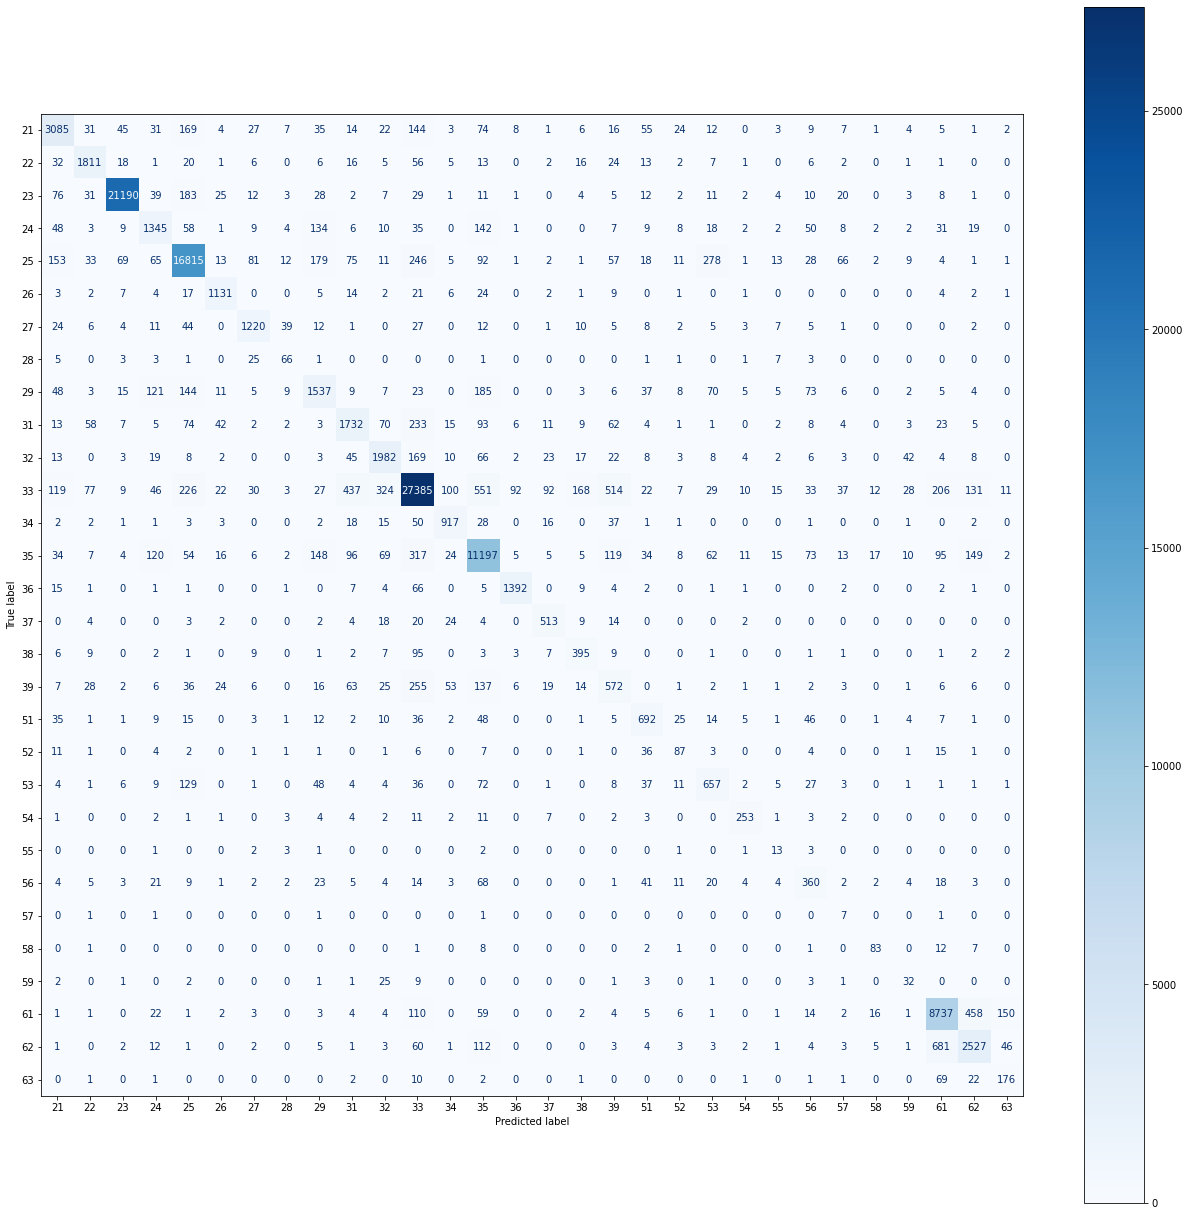

In [ ]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##LinearSVM

In [ ]:
#For large datasets consider using LinearSVC
parametersSVM = { 
                 'max_iter':[100, 200, 300, 500, 700],
                 'C':[1]
                 }
modelSVM = LinearSVC(C=1.0, 
                     penalty='l2', 
                     class_weight='balanced', 
                     random_state=42, 
                     max_iter=1000, 
                     verbose=3)

In [ ]:
#Model and hyperparameters
clf_GS_SVM = GridSearchCV(modelSVM, parametersSVM, cv=2, n_jobs=-1, verbose=10)
clf_GS_SVM.fit(X_train_Tfidf, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


GridSearchCV(cv=2,
             estimator=LinearSVC(class_weight='balanced', random_state=42,
                                 verbose=3),
             n_jobs=-1,
             param_grid={'C': [1], 'max_iter': [100, 200, 300, 500, 700]},
             verbose=10)

In [ ]:
# Let's see the results
y_pred = clf_GS_SVM.predict(X_test_Tfidf)
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'C': 1, 'max_iter': 100}

Grid scores on testing set:

0.888 (+/-0.000) for {'C': 1, 'max_iter': 100}
0.888 (+/-0.000) for {'C': 1, 'max_iter': 200}
0.888 (+/-0.000) for {'C': 1, 'max_iter': 300}
0.888 (+/-0.000) for {'C': 1, 'max_iter': 500}
0.888 (+/-0.000) for {'C': 1, 'max_iter': 700}

best score:  0.8877997294409545

Grid times on testing set:

257.157 seconds (+/-11.771) for {'C': 1, 'max_iter': 100}
277.567 seconds (+/-30.015) for {'C': 1, 'max_iter': 200}
289.414 seconds (+/-3.927) for {'C': 1, 'max_iter': 300}
286.010 seconds (+/-37.511) for {'C': 1, 'max_iter': 500}
260.373 seconds (+/-5.596) for {'C': 1, 'max_iter': 700}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.7598962423113318, 'accuracy': 0.9000599607824071}
              precision    recall  f1-score   support

          21       0.85      0.8

<Figure size 432x288 with 0 Axes>

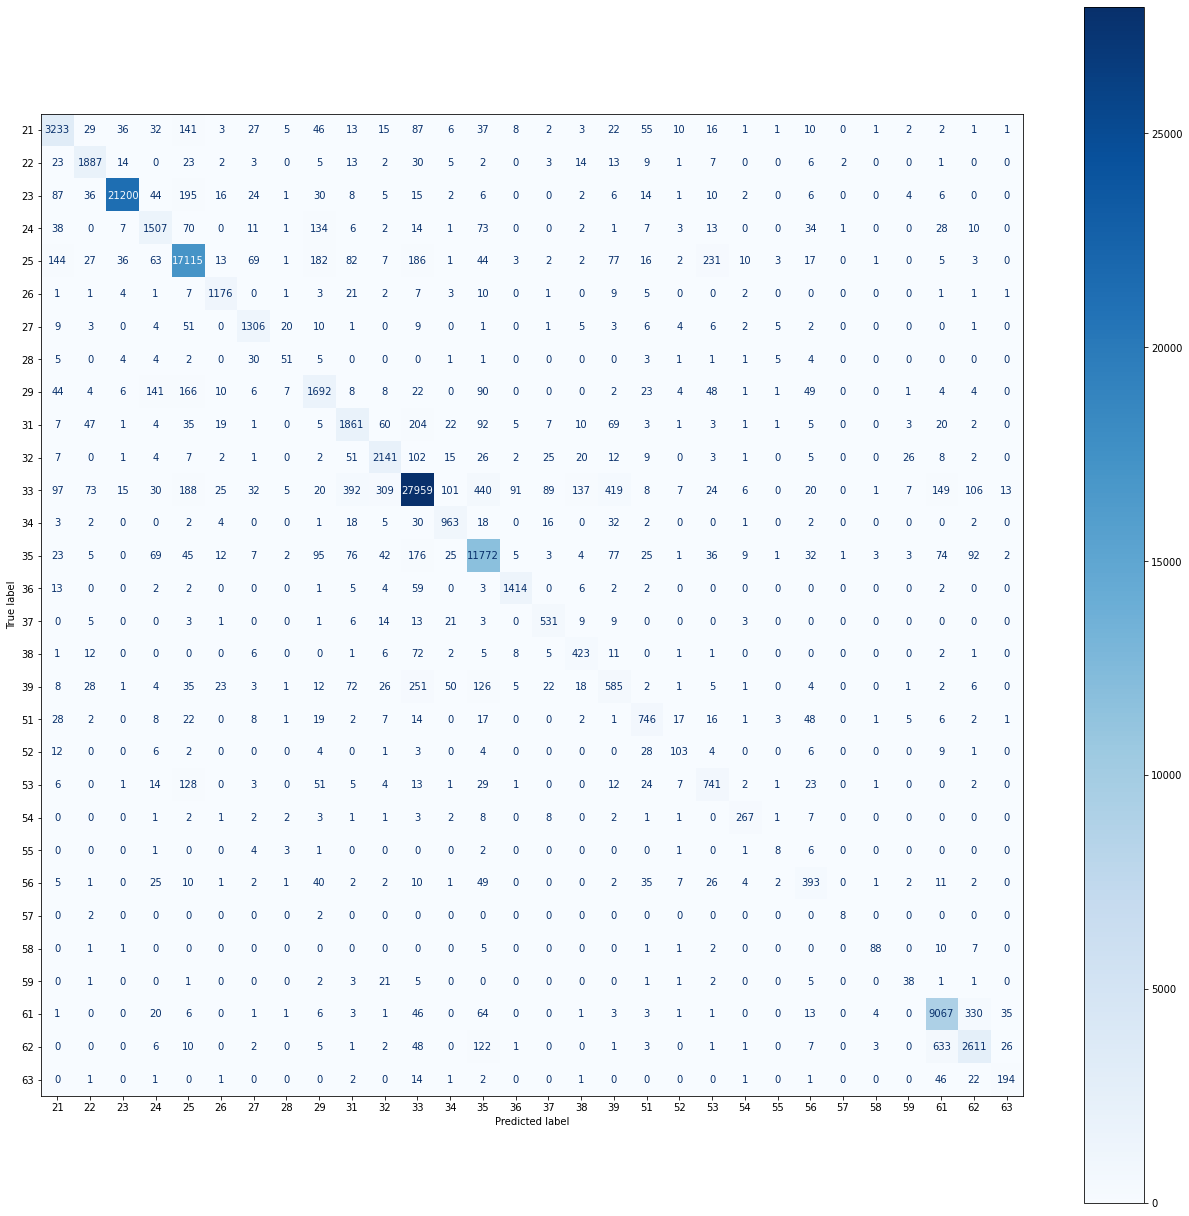

In [ ]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##SGDClassifier

In [ ]:
#Model and hyperparameters
parametersSGD = { 
                 'max_iter':[100, 200, 300, 500],
                 'loss':['modified_huber', 'squared_hinge', 'perceptron']
                 }
modelSGD = SGDClassifier(loss='perceptron', 
                         penalty='l2',
                         max_iter=1000, 
                         n_jobs=-1,
                         class_weight='balanced', 
                         early_stopping=True,
                         random_state=42, 
                         verbose=2)

In [ ]:
#Model and hyperparameters
clf_GS_SGD = GridSearchCV(modelSGD, parametersSGD, cv=2, n_jobs=-1, verbose=10)
clf_GS_SGD.fit(X_train_Tfidf, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 16.27, NNZs: 965024, Bias: -0.948552, T: 444287, Avg. loss: 0.020166
Total training time: 0.38 seconds.
-- Epoch 2
Norm: 15.05, NNZs: 1126177, Bias: -0.913946, T: 444287, Avg. loss: 0.045968
Total training time: 0.41 seconds.
-- Epoch 2
Norm: 15.99, NNZs: 1129321, Bias: -0.941964, T: 888574, Avg. loss: 0.016817
Total training time: 0.93 seconds.
-- Epoch 3
Norm: 14.91, NNZs: 1250774, Bias: -0.915575, T: 888574, Avg. loss: 0.041547
Total training time: 0.96 seconds.
-- Epoch 3
Norm: 15.90, NNZs: 1161885, Bias: -0.949324, T: 1332861, Avg. loss: 0.016552
Total training time: 1.46 seconds.
-- Epoch 4
Norm: 14.88, NNZs: 1274857, Bias: -0.918731, T: 1332861, Avg. loss: 0.041262
Total training time: 1.53 seconds.
-- Epoch 4
Norm: 15.91, NNZs: 1172276, Bias: -0.943828, T: 1777148, Avg. loss: 0.016451
Total training time: 2.01 seconds.
-- Epoch 5
Norm: 14.84, NNZs: 1282973, Bias: -0.913546, T: 1777148, Avg. loss: 0.041097
Total training time: 2.10 seconds.
-- Epoch 5

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   55.9s finished


GridSearchCV(cv=2,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True, loss='perceptron',
                                     n_jobs=-1, random_state=42, verbose=2),
             n_jobs=-1,
             param_grid={'loss': ['modified_huber', 'squared_hinge',
                                  'perceptron'],
                         'max_iter': [100, 200, 300, 500]},
             verbose=10)

In [ ]:
# Let's see the results
y_pred = clf_GS_SGD.predict(X_test_Tfidf)
#Model performance
describe_performance(clf_GS_SGD, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'loss': 'modified_huber', 'max_iter': 100}

Grid scores on testing set:

0.852 (+/-0.002) for {'loss': 'modified_huber', 'max_iter': 100}
0.852 (+/-0.002) for {'loss': 'modified_huber', 'max_iter': 200}
0.852 (+/-0.002) for {'loss': 'modified_huber', 'max_iter': 300}
0.852 (+/-0.002) for {'loss': 'modified_huber', 'max_iter': 500}
0.852 (+/-0.001) for {'loss': 'squared_hinge', 'max_iter': 100}
0.852 (+/-0.001) for {'loss': 'squared_hinge', 'max_iter': 200}
0.852 (+/-0.001) for {'loss': 'squared_hinge', 'max_iter': 300}
0.852 (+/-0.001) for {'loss': 'squared_hinge', 'max_iter': 500}
0.848 (+/-0.004) for {'loss': 'perceptron', 'max_iter': 100}
0.848 (+/-0.004) for {'loss': 'perceptron', 'max_iter': 200}
0.848 (+/-0.004) for {'loss': 'perceptron', 'max_iter': 300}
0.848 (+/-0.004) for {'loss': 'perceptron', 'max_iter': 500}

best score:  0.8518372197505879

Grid times on testing set:

61.827 seconds (+/-6.520) for {'loss': 'mo

In [ ]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

#cAPITULO

In [ ]:
#For large datasets consider using LinearSVC
model = LinearSVC(C=1.0, penalty='l2', class_weight='balanced', random_state=42, max_iter=1000, verbose=1)

In [ ]:
# Entrenamiento del algoritmo 
model.fit(X_train_Tfidf, y_train)

[LibLinear]

LinearSVC(class_weight='balanced', random_state=42, verbose=1)

In [ ]:
# Let's see the results
y_pred = model.predict(X_test_Tfidf)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2000       0.94      0.94      0.94      4307
        3000       0.95      0.92      0.93      4298
        5000       0.55      0.65      0.60       284
        6000       0.91      0.93      0.92      1111

    accuracy                           0.93     10000
   macro avg       0.84      0.86      0.85     10000
weighted avg       0.93      0.93      0.93     10000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

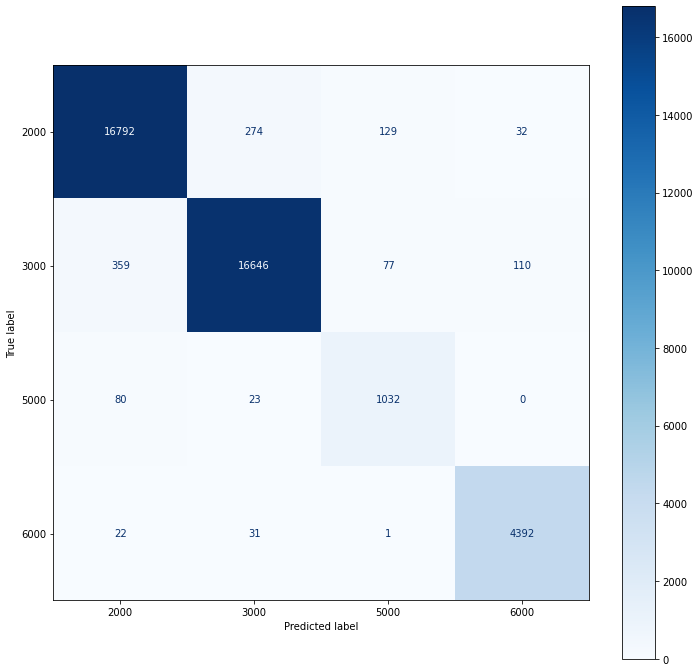

In [ ]:
#Confusion matrix train
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
metrics.plot_confusion_matrix(model, X_train_Tfidf, y_train, cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.show() 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

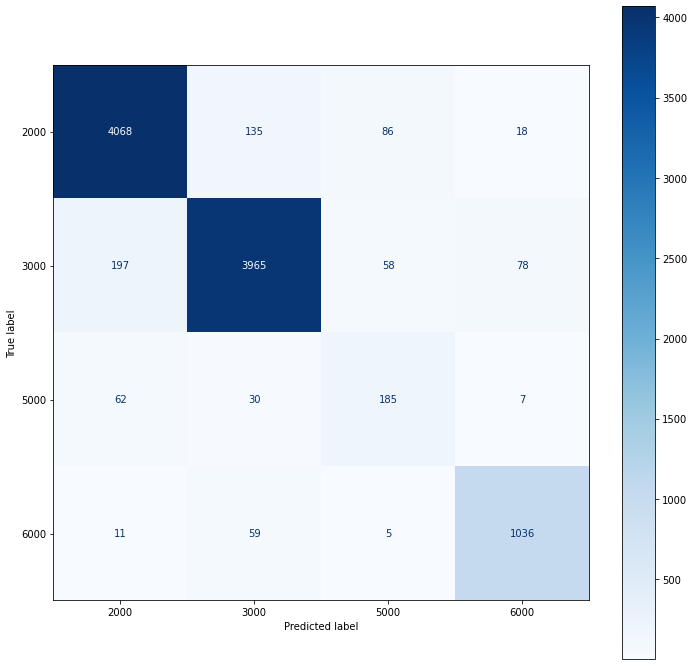

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
metrics.plot_confusion_matrix(model, X_test_Tfidf, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.show() 

In [ ]:
# Finally, let's try the examples
examples = ["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de papelería y oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"]
examples = [preprocessing_fastest_v2(example) for example in examples]
examples

['semilla sembrar',
 'alquiler paramo',
 'obrar metro remodelación',
 'material papelería oficina',
 'grúa demolición',
 'gruas demolicion']

In [ ]:
examples_Tfidf = tfidf_vect.transform(examples)
examples_Tfidf.shape

(6, 22357)

In [ ]:
#Prediction
test = model.predict(examples_Tfidf)
test

array([2000, 3000, 6000, 2000, 5000, 6000])

Pipeline solo el TF-IDF y MODEL



In [ ]:
# Everything looks ok. Now let's do the train-split as we did before.
X = df['clean_text'] # Text
Y = df['id_capitulo'] # Labels

In [ ]:
# Training = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle = True, random_state=0)

In [ ]:
# Convert lemmatized words to Tf-Idf feature vectors
tfidf_pl = TfidfVectorizer(analyzer="word", tokenizer=word_tokenize, strip_accents='ascii', max_features=None, lowercase=True)
#NO SE SI HACER UN FIT ANTES DEL TFIDF

In [ ]:
#For large datasets consider using LinearSVC
model_pl = LinearSVC(C=1.0, penalty='l2', class_weight='balanced', random_state=42, max_iter=1000, verbose=1)

In [ ]:
#Model
clf_pl = Pipeline([
    ('vectorizer', tfidf_pl),
    ('svm', model_pl)
])
clf_pl.fit(X_train, y_train)

[LibLinear]

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(strip_accents='ascii',
                                 tokenizer=<function word_tokenize at 0x7fd305323e60>)),
                ('svm',
                 LinearSVC(class_weight='balanced', random_state=42,
                           verbose=1))])

In [ ]:
# Let's see the results
y_pred = clf_pl.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2000       0.94      0.94      0.94      4307
        3000       0.95      0.92      0.93      4298
        5000       0.54      0.65      0.59       284
        6000       0.91      0.94      0.92      1111

    accuracy                           0.92     10000
   macro avg       0.83      0.86      0.85     10000
weighted avg       0.93      0.92      0.93     10000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

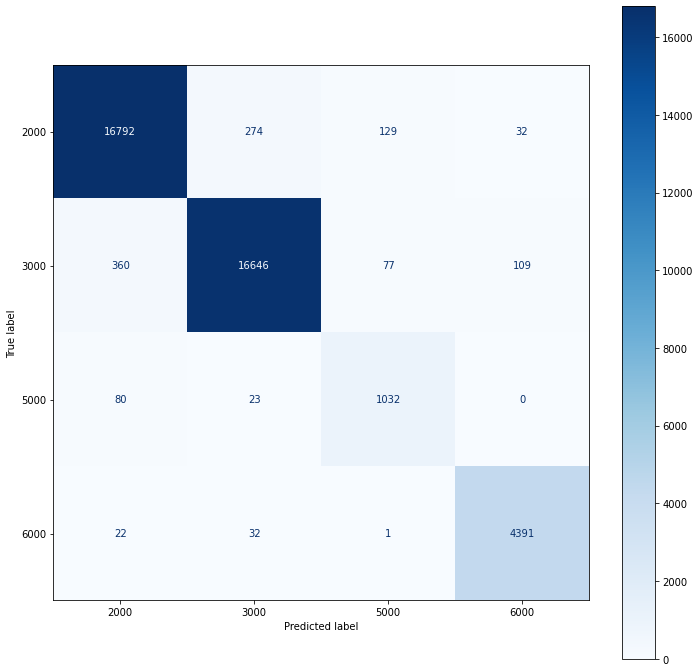

In [ ]:
#Confusion matrix train
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
metrics.plot_confusion_matrix(clf_pl, X_train, y_train, cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.show() 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

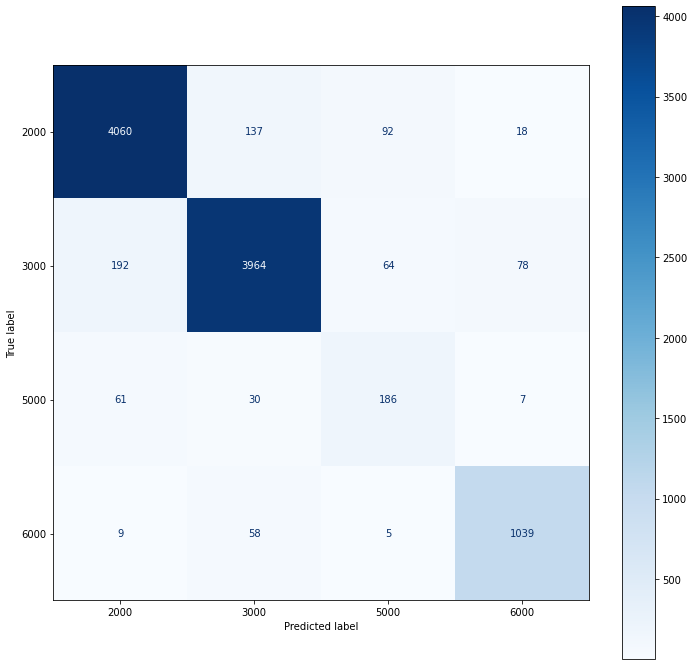

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
metrics.plot_confusion_matrix(clf_pl, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.show() 

In [ ]:
# Finally, let's try the examples
examples = ["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de papelería y oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"]
examples = [preprocessing_fastest_v2(example) for example in examples]
examples

['semilla sembrar',
 'alquiler paramo',
 'obrar metro remodelación',
 'material papelería oficina',
 'grúa demolición',
 'gruas demolicion']

In [ ]:
#Prediction
test = clf_pl.predict(examples)
test

array([2000, 3000, 6000, 2000, 5000, 5000])

Pipeline Preprocess, TF-IDF y Model

In [ ]:
#Este metodo es para pipelenizar una funcion 
transformer = FunctionTransformer(preprocessing_fastest_v2)
start = time.time()
print(transformer.transform('SERVICIOS PROFESIONALES CONSISTENTES EN LA COORDINACIÓN DEL PROGRAMA CULTURAL DEL PROYECTO BOSQUE DE CHAPULTEPEC NATURALEZA Y CULTURA, A TRAVÉS DE SUS EJES: LA CONEXIÓN ENTRE LO BIOLÓGICO Y LO CULTURAL'))
end = time.time()
print(end - start)

servicio profesional consistente coordinación programar cultural proyectar bosque chapultepec naturaleza cultura través eje conexión biológico cultural
0.02160477638244629


In [ ]:
def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

In [ ]:
# Everything looks ok. Now let's do the train-split as we did before.
X = df['descripcion'] # Text
Y = df['id_capitulo'] # Labels

In [ ]:
# Training = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle = True, random_state=0)

In [ ]:
# Convert lemmatized words to Tf-Idf feature vectors
tfidf_all = TfidfVectorizer(analyzer="word", tokenizer=word_tokenize, strip_accents='ascii', max_features=None, lowercase=True)
#NO SE SI HACER UN FIT ANTES DEL TFIDF

In [ ]:
#For large datasets consider using LinearSVC
model_all = LinearSVC(C=1.0, penalty='l2', class_weight='balanced', random_state=42, max_iter=1000, verbose=1)

In [ ]:
#Model
clf_all = Pipeline([
    ('preprocess', pipelinize(preprocessing_fastest_v2)),
    ('vectorizer', tfidf_all),
    ('svm', model_all)
])
clf_all.fit(X_train, y_train)

[LibLinear]

Pipeline(steps=[('preprocess',
                 FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7fd2f1fe9f80>,
                                     kw_args={'active': True})),
                ('vectorizer',
                 TfidfVectorizer(strip_accents='ascii',
                                 tokenizer=<function word_tokenize at 0x7fd305323e60>)),
                ('svm',
                 LinearSVC(class_weight='balanced', random_state=42,
                           verbose=1))])

In [ ]:
# Let's see the results
y_pred = clf_all.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2000       0.94      0.94      0.94      4307
        3000       0.95      0.92      0.93      4298
        5000       0.54      0.65      0.59       284
        6000       0.91      0.94      0.92      1111

    accuracy                           0.92     10000
   macro avg       0.83      0.86      0.85     10000
weighted avg       0.93      0.92      0.93     10000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

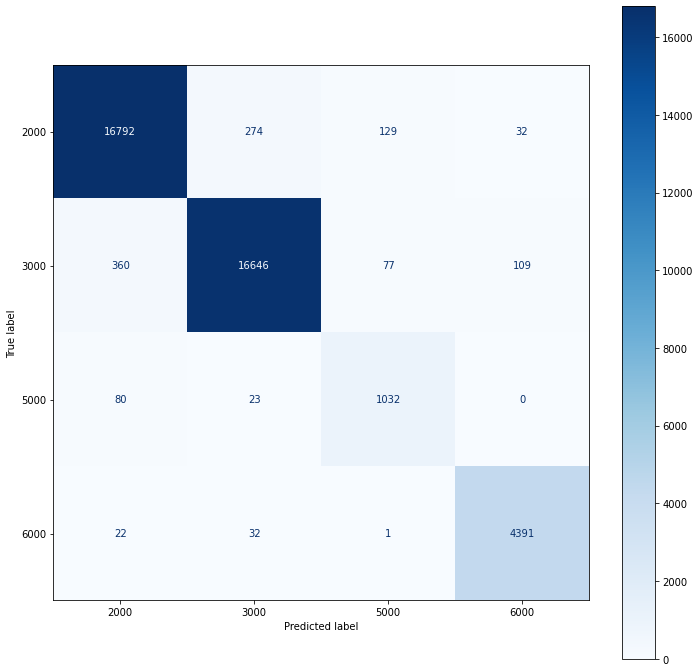

In [ ]:
#Confusion matrix train
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
metrics.plot_confusion_matrix(clf_all, X_train, y_train, cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.show() 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

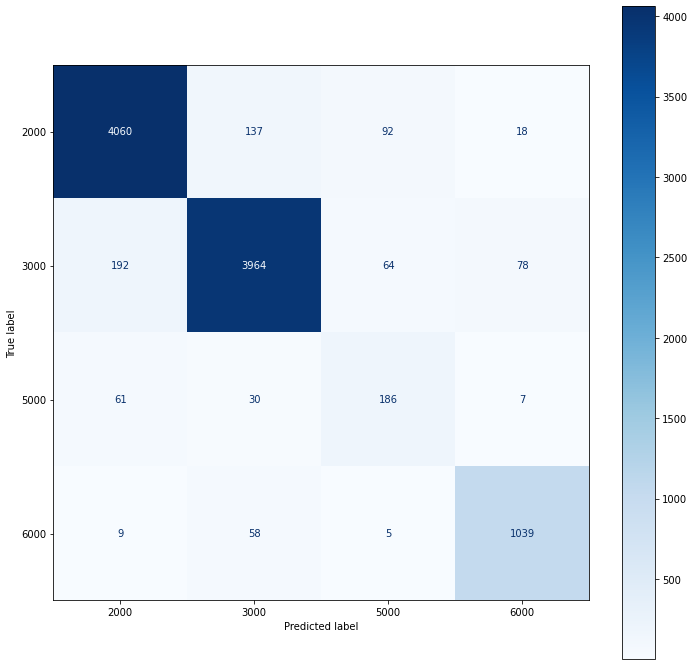

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
metrics.plot_confusion_matrix(clf_all, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.show() 

<Figure size 432x288 with 0 Axes>

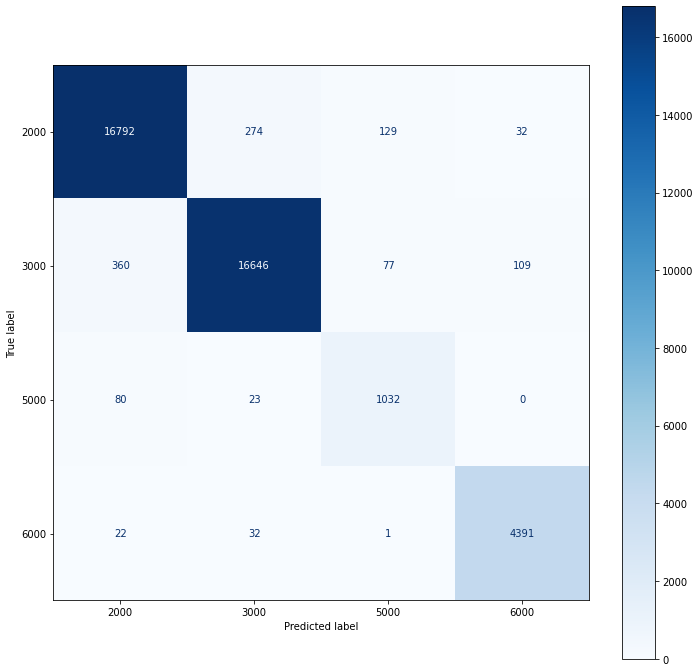

In [ ]:
#Confusion matrix train
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
ConfusionMatrixDisplay.from_estimator(clf_all, X_train, y_train, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

<Figure size 432x288 with 0 Axes>

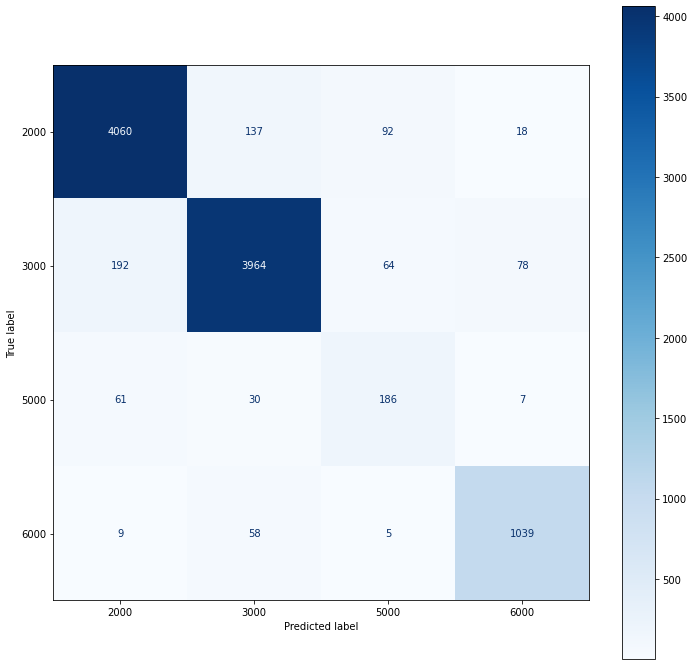

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

In [ ]:
# Finally, let's try the examples again: No es necesario hacer ningún preprocess
test = clf_all.predict(["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de papelería y oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"])
test

array([2000, 3000, 6000, 2000, 5000, 6000])

**MODELO PARA CONCEPTO**

In [ ]:
df.groupby(['id_concepto']).count()

,id_capitulo,id_partida_generica,descripcion,clean_text
id_concepto,,,,
2100,1600,1600,1600,1600
2200,795,795,795,795
2300,8728,8728,8728,8728
2400,829,829,829,829
2500,7552,7552,7552,7552
2600,508,508,508,508
2700,562,562,562,562
2800,44,44,44,44
2900,916,916,916,916


In [ ]:
# Everything looks ok. Now let's do the train-split as we did before.
X = df['clean_text'] # Text
Y = df['id_concepto'] # Labels

In [ ]:
# Training = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle = True, random_state=0)

In [ ]:
# Convert lemmatized words to Tf-Idf feature vectors
tfidf_conc = TfidfVectorizer(analyzer="word", tokenizer=word_tokenize, strip_accents='ascii', max_features=None, lowercase=True)

In [ ]:
#For large datasets consider using LinearSVC
model_conc = LinearSVC(C=1.0, penalty='l2', class_weight='balanced', random_state=42, max_iter=1000, verbose=1)

In [ ]:
#Model
clf_conc = Pipeline([
    ('vectorizer', tfidf_conc),
    ('svm', model_conc)
])
clf_conc.fit(X_train, y_train)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(strip_accents='ascii',
                                 tokenizer=<function word_tokenize at 0x7fd305323e60>)),
                ('svm',
                 LinearSVC(class_weight='balanced', random_state=42,
                           verbose=1))])

In [ ]:
# Let's see the results
y_pred = clf_conc.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2100       0.76      0.73      0.75       320
        2200       0.73      0.81      0.76       159
        2300       0.99      0.96      0.97      1746
        2400       0.57      0.60      0.58       166
        2500       0.87      0.89      0.88      1510
        2600       0.78      0.92      0.85       101
        2700       0.68      0.77      0.72       112
        2800       0.20      0.44      0.28         9
        2900       0.59      0.54      0.56       183
        3100       0.53      0.62      0.57       205
        3200       0.74      0.77      0.76       190
        3300       0.94      0.84      0.89      2487
        3400       0.67      0.78      0.72        78
        3500       0.87      0.85      0.86      1008
        3600       0.81      0.92      0.87       118
        3700       0.68      0.85      0.76        53
        3800       0.46      0.48      0.47        48
        3900       0.22    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

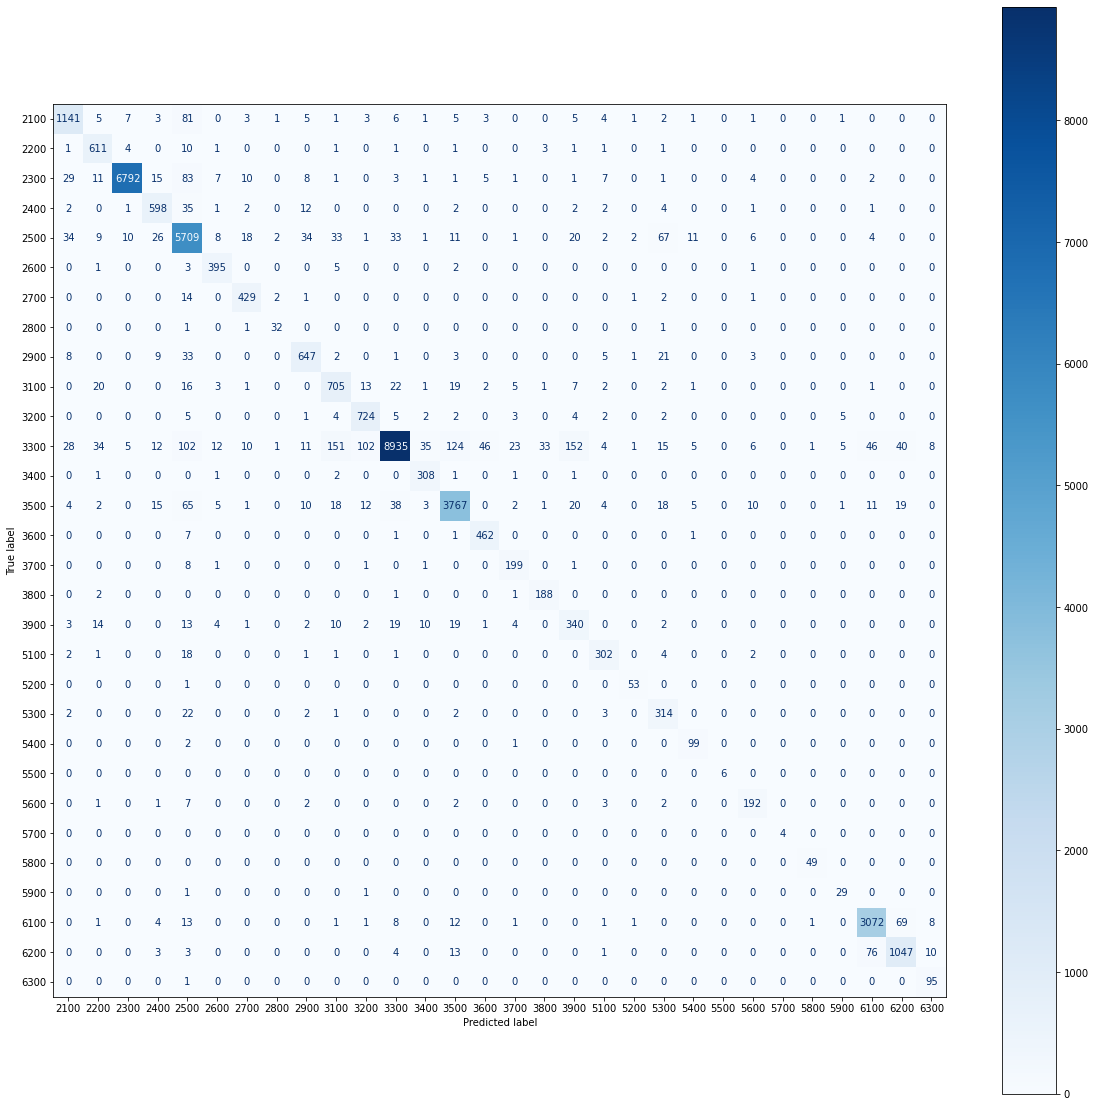

In [ ]:
#Confusion matrix train
plt.clf()
fig,ax = plt.subplots(figsize=(20,20))
ConfusionMatrixDisplay.from_estimator(clf_conc, X_train, y_train, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 


<Figure size 432x288 with 0 Axes>

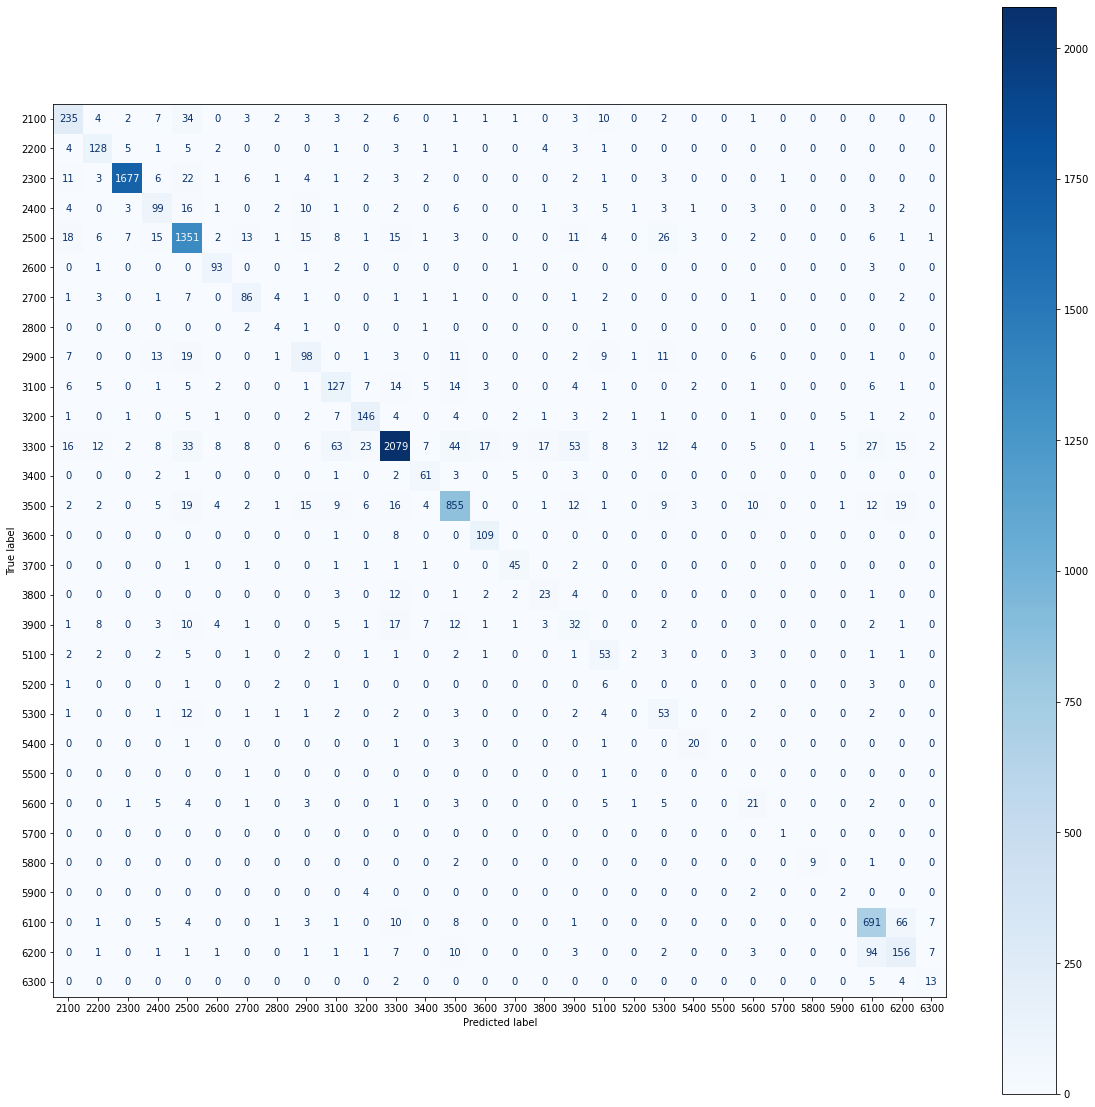

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(20,20))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show()

In [ ]:
# Finally, let's try the examples
examples = ["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de papelería y oficina", 
                   "Grúas para demolición",
                   "Grua para demolicion"]
examples = [preprocessing_fastest_v2(example) for example in examples]
examples

['semilla sembrar',
 'alquiler paramo',
 'obrar metro remodelación',
 'material papelería oficina',
 'grúa demolición',
 'grua demolicion']

In [ ]:
#Prediction
test = clf_conc.predict(examples)
test

array([3300, 2500, 6200, 2100, 5600, 5600])

Con valores por default para TF-IDF y Model

In [ ]:
# Everything looks ok. Now let's do the train-split as we did before.
X = df['clean_text'] # Text
Y = df['id_concepto'] # Labels

In [ ]:
# Training = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle = True, random_state=0)

In [ ]:
# Classify
clf_Concepto = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('linearsvc', LinearSVC(random_state=42))
])
clf_Concepto.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('linearsvc', LinearSVC(random_state=42))])

In [ ]:
# Let's see the results
y_pred = clf_Concepto.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2100       0.81      0.70      0.75       320
        2200       0.78      0.79      0.79       159
        2300       0.97      0.97      0.97      1746
        2400       0.72      0.51      0.59       166
        2500       0.82      0.94      0.87      1510
        2600       0.88      0.87      0.88       101
        2700       0.80      0.74      0.77       112
        2800       0.67      0.22      0.33         9
        2900       0.70      0.50      0.58       183
        3100       0.71      0.54      0.61       205
        3200       0.84      0.72      0.77       190
        3300       0.88      0.92      0.90      2487
        3400       0.80      0.63      0.71        78
        3500       0.83      0.88      0.86      1008
        3600       0.92      0.86      0.89       118
        3700       0.75      0.74      0.74        53
        3800       0.65      0.27      0.38        48
        3900       0.56    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

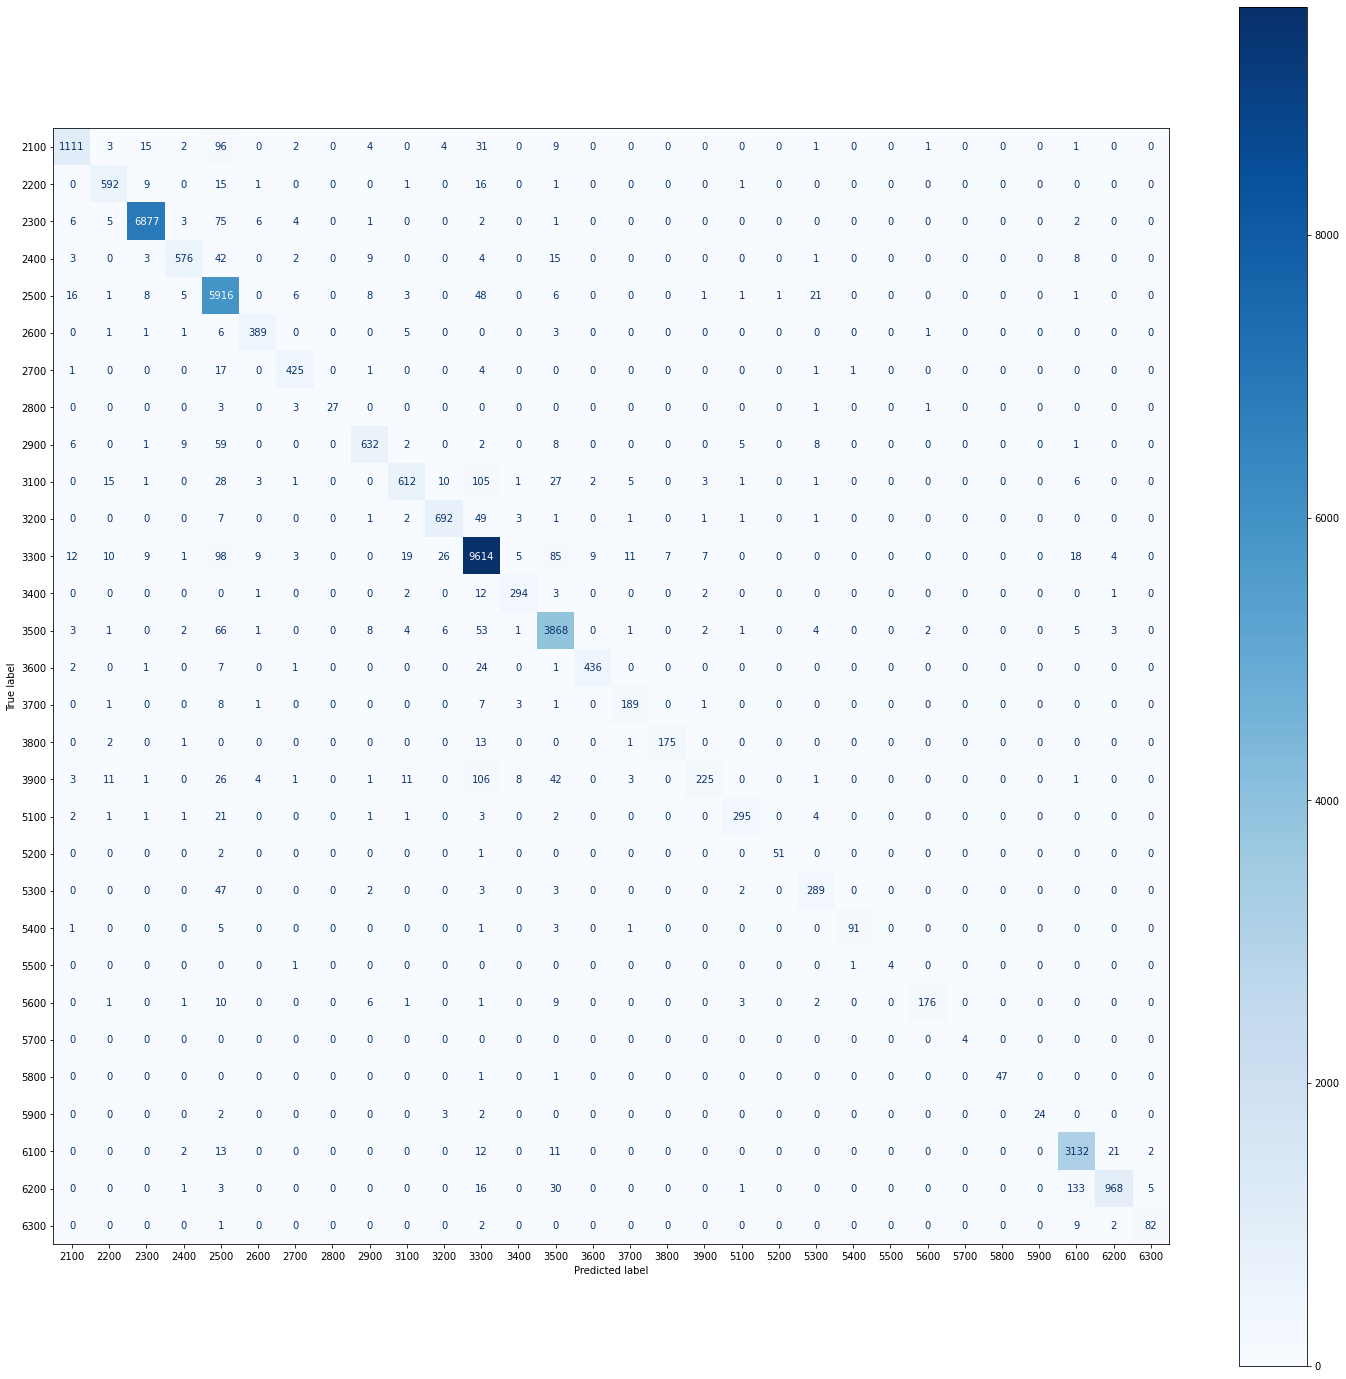

In [ ]:
#Confusion matrix train
plt.clf()
fig,ax = plt.subplots(figsize=(25,25))
ConfusionMatrixDisplay.from_estimator(clf_Concepto, X_train, y_train, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 


<Figure size 432x288 with 0 Axes>

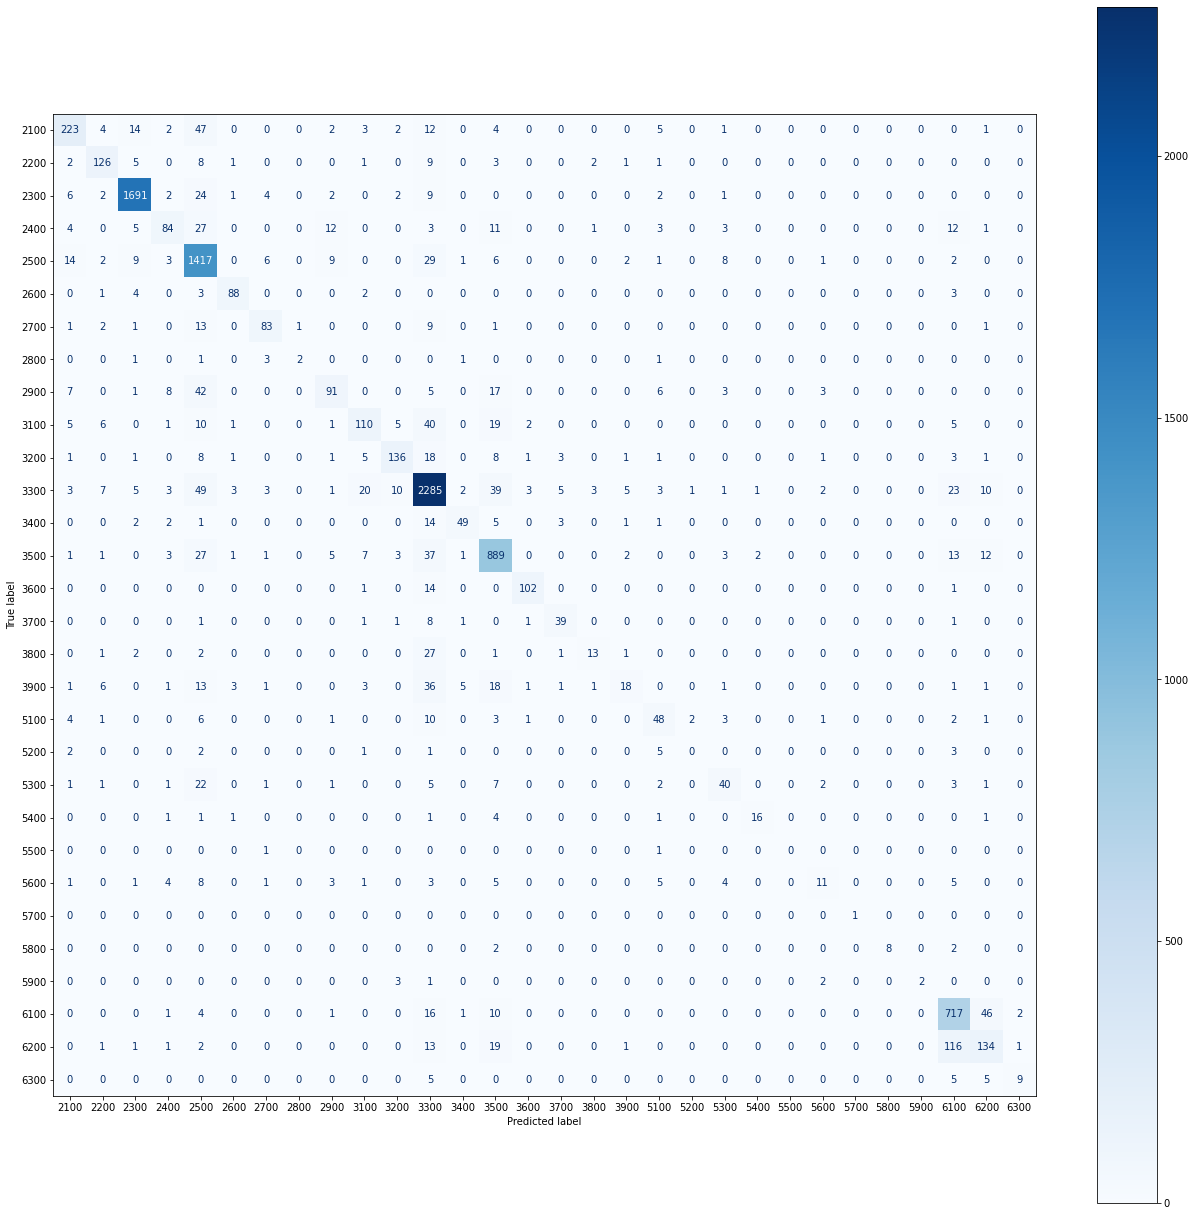

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(22,22))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

In [ ]:
# Finally, let's try the examples
examples = ["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de papelería y oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"]
examples = [preprocessing_fastest_v2(example) for example in examples]
examples

['semilla sembrar',
 'alquiler paramo',
 'obrar metro remodelación',
 'material papelería oficina',
 'grúa demolición',
 'gruas demolicion']

In [ ]:
#Prediction
test = clf_Concepto.predict(examples)
test

array([3300, 2500, 6200, 2100, 5600, 2500])